<a href="https://colab.research.google.com/github/Rustydinoco/ML_Learning/blob/master/LSTM_S%24P_500_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as f
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
%matplotlib inline

In [13]:
ticker = "^GSPC"
df = yf.download(ticker, start="2010-01-01")
df

/tmp/ipython-input-13-1899151477.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start="2010-01-01")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,
2010-01-04,1132.989990,1133.869995,1116.560059,1116.560059,3991400000
2010-01-05,1136.520020,1136.630005,1129.660034,1132.660034,2491020000
2010-01-06,1137.140015,1139.189941,1133.949951,1135.709961,4972660000
2010-01-07,1141.689941,1142.459961,1131.319946,1136.270020,5270680000
2010-01-08,1144.979980,1145.390015,1136.219971,1140.520020,4389590000
...,...,...,...,...,...
2025-06-23,6025.169922,6028.770020,5943.229980,5969.669922,5597000000
2025-06-24,6092.180176,6101.759766,6059.250000,6061.209961,5443690000


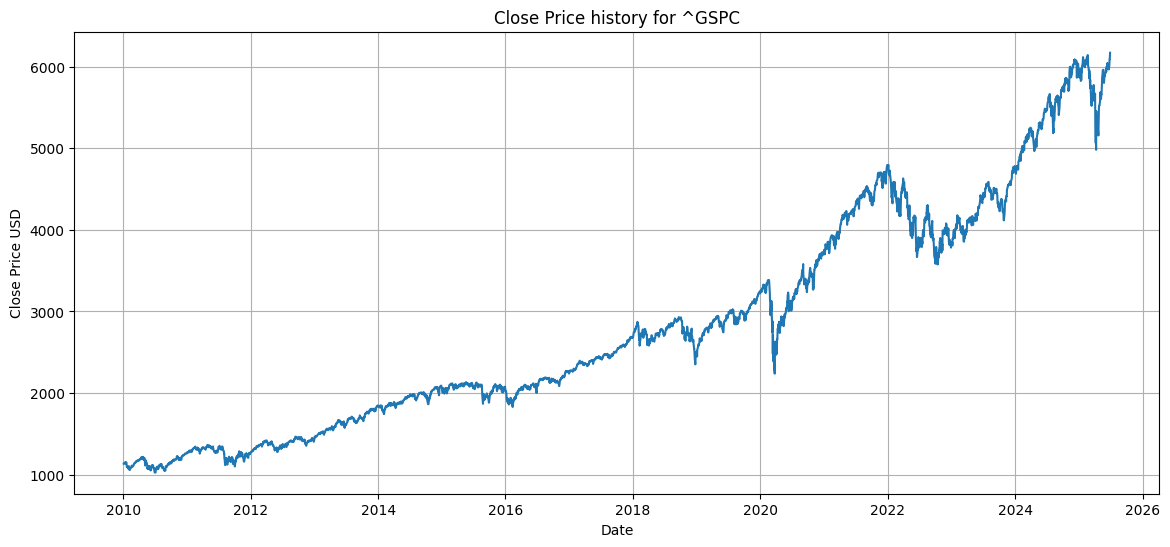

In [14]:
close_price = df["Close"]

plt.figure(figsize=(14, 6))
plt.title(f"Close Price history for {ticker}")
plt.plot(df["Close"])
plt.xlabel("Date")
plt.ylabel("Close Price USD")
plt.grid(True)
plt.show()

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3895 entries, 2010-01-04 to 2025-06-27
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   (Close, ^GSPC)   3895 non-null   float64
 1   (High, ^GSPC)    3895 non-null   float64
 2   (Low, ^GSPC)     3895 non-null   float64
 3   (Open, ^GSPC)    3895 non-null   float64
 4   (Volume, ^GSPC)  3895 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 182.6 KB


In [16]:
df.shape

(3895, 5)

In [17]:
df.isnull().sum()

,,0
Price,Ticker,
Close,^GSPC,0
High,^GSPC,0
Low,^GSPC,0
Open,^GSPC,0
Volume,^GSPC,0


In [18]:
#Scala The Data
MinMaxScaler = MinMaxScaler()
df_scaled = MinMaxScaler.fit_transform(close_price)
df_scaked = pd.DataFrame(df_scaled, columns=close_price.columns)
df_scaled

array([[0.02143679],
       [0.02212217],
       [0.02224254],
       ...,
       [0.98429088],
       [0.99377733],
       [1.        ]])

In [19]:
#Create Data Windows

def create_dataset(dataset, look_back = 60):
  X,Y = [],[]
  for i in range(len(dataset) - look_back):
    a = dataset[i:(i + look_back), 0]
    X.append(a)
    Y.append(dataset[i + look_back, 0]) # Predict the next step

  return np.array(X), np.array(Y)

look_back = 60
train_size = int(len(df_scaled)*0.8)
test_size = len(df_scaled) - train_size
train_data, test_data = df_scaled[0:train_size, :], df_scaled[train_size - look_back: len(df_scaled), :]

X_train, y_train = create_dataset(train_data, look_back)
X_test, y_test = create_dataset(test_data, look_back)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

X_train = X_train.view(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.view(X_test.shape[0], X_test.shape[1], 1)

batch_size = 32
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [20]:
class LSTMMOdel(nn.Module):
  def __init__(self, input_size = 1, hidden_layer_size  = 50, output= 1):
    super().__init__()
    self.hidden_layer_size = hidden_layer_size
    self.lstm = nn.LSTM(input_size, hidden_layer_size)
    self.linear = nn.Linear(hidden_layer_size, output)

  def forward(self, input_seq):
    lstm_out, _ = self.lstm(input_seq)
    prediction = self.linear(lstm_out[:, -1, :])
    return prediction

torch.manual_seed(42)
model = LSTMMOdel()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)


In [21]:
epochs = 100
loss = []

for i in range (epochs):
  y_pred = model.forward(X_train)
  losses = loss_function(y_pred, y_train)
  loss.append(losses.detach().numpy())
  if i % 10 == 0:
    print(f"Epoch: {i} Loss: {losses.item()}")


  optimizer.zero_grad()
  losses.backward()
  optimizer.step()

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([3056])) that is different to the input size (torch.Size([3056, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0 Loss: 0.17507420480251312
Epoch: 10 Loss: 0.09575816243886948
Epoch: 20 Loss: 0.035404663532972336
Epoch: 30 Loss: 0.03523533418774605
Epoch: 40 Loss: 0.035159554332494736
Epoch: 50 Loss: 0.03377964720129967
Epoch: 60 Loss: 0.033937763422727585
Epoch: 70 Loss: 0.03375941142439842
Epoch: 80 Loss: 0.03373400494456291
Epoch: 90 Loss: 0.03373416140675545


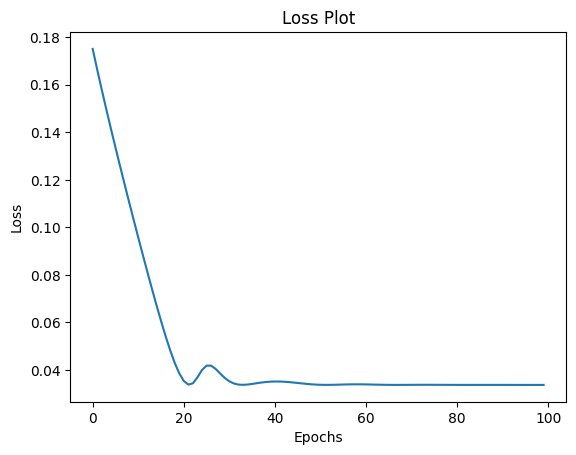

In [26]:
plt.plot(range(epochs), loss)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Plot")
plt.show()